In [1]:
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
from sklearn.manifold import TSNE
import seaborn as sns
import sys
import pickle
import pandas as pd

In [2]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils import set_seed, log_results, load_model
from models.vit import VisionTransformer
from models.performer_relu import PerformerReLUTransformer
from models.performer_exp import PerformerExpTransformer
from models.performer_f_theta import PerformerLearnableTransformer
os.chdir('..')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count() if os.cpu_count() is not None else 4
print(f"using device: {device}, num_workers: {num_workers}")

# Set seed for reproducibility
set_seed(42)

# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    ),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    ),
])

using device: cpu, num_workers: 11


In [4]:
# Load datasets
train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# Create data loaders
batch_size = 256
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Define criterion
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Initialize models with adjusted parameters for efficiency
vit_model = VisionTransformer(
    img_size=32,
    patch_size=8,            # Increased patch size from 4 to 8
    in_channels=3,
    num_classes=10,
    embed_dim=128,           # Reduced embedding dimension from 256 to 128
    num_heads=4,             # Reduced number of heads from 8 to 4
    hidden_dim=256,          # Reduced hidden dimension from 512 to 256
    num_layers=4,            # Reduced number of layers from 6 to 4
    dropout=0.1
).to(device)

performer_relu_model = PerformerReLUTransformer(
    img_size=32,
    patch_size=8,            # Increased patch size from 4 to 8
    in_channels=3,
    num_classes=10,
    embed_dim=128,           # Reduced embedding dimension from 256 to 128
    num_heads=4,             # Reduced number of heads from 8 to 4
    hidden_dim=256,          # Reduced hidden dimension from 512 to 256
    num_layers=4,            # Reduced number of layers from 6 to 4
    dropout=0.1
).to(device)

performer_exp_model = PerformerExpTransformer(
    img_size=32,
    patch_size=8,            # Increased patch size from 4 to 8
    in_channels=3,
    num_classes=10,
    embed_dim=128,           # Reduced embedding dimension from 256 to 128
    num_heads=4,             # Reduced number of heads from 8 to 4
    hidden_dim=256,          # Reduced hidden dimension from 512 to 256
    num_layers=4,            # Reduced number of layers from 6 to 4
    num_features=128,        # Adjusted num_features to match reduced embed_dim
    dropout=0.1
).to(device)

performer_learnable_model = PerformerLearnableTransformer(
    img_size=32,
    patch_size=8,            # Increased patch size from 4 to 8
    in_channels=3,
    num_classes=10,
    embed_dim=128,           # Reduced embedding dimension from 256 to 128
    num_heads=4,             # Reduced number of heads from 8 to 4
    hidden_dim=256,          # Reduced hidden dimension from 512 to 256
    num_layers=4,            # Reduced number of layers from 6 to 4
    num_features=128,        # Adjusted num_features to match reduced embed_dim
    dropout=0.1
).to(device)

# Define optimizers
optimizer_vit = optim.AdamW(vit_model.parameters(), lr=0.001, weight_decay=0.01)
optimizer_relu = optim.AdamW(performer_relu_model.parameters(), lr=0.001, weight_decay=0.01)
optimizer_exp = optim.AdamW(performer_exp_model.parameters(), lr=0.001, weight_decay=0.01)
optimizer_learnable = optim.AdamW(performer_learnable_model.parameters(), lr=0.001, weight_decay=0.01)

# Define schedulers
scheduler_vit = optim.lr_scheduler.CosineAnnealingLR(optimizer_vit, T_max=50)
scheduler_relu = optim.lr_scheduler.CosineAnnealingLR(optimizer_relu, T_max=50)
scheduler_exp = optim.lr_scheduler.CosineAnnealingLR(optimizer_exp, T_max=50)
scheduler_learnable = optim.lr_scheduler.CosineAnnealingLR(optimizer_learnable, T_max=50)


In [6]:
# Models dictionary
models = {
    "ViT": {
        "model": vit_model,
        "optimizer": optimizer_vit,
        "scheduler": scheduler_vit,
    },
    "Performer-ReLU": {
        "model": performer_relu_model,
        "optimizer": optimizer_relu,
        "scheduler": scheduler_relu,
    },
    "Performer-exp": {
        "model": performer_exp_model,
        "optimizer": optimizer_exp,
        "scheduler": scheduler_exp,
    },
    "Performer-Learnable": {
        "model": performer_learnable_model,
        "optimizer": optimizer_learnable,
        "scheduler": scheduler_learnable,
    },
}


In [7]:
for model_name, components in models.items():
        model = components["model"]
        optimizer = components["optimizer"]
        scheduler = components["scheduler"]
        
        # Check if a checkpoint exists
        checkpoint_path = f'best_{model_name}.pth'
        print(checkpoint_path)


best_ViT.pth
best_Performer-ReLU.pth
best_Performer-exp.pth
best_Performer-Learnable.pth


In [45]:
if os.path.exists(checkpoint_path):
    print(f"\nLoading checkpoint for {model_name} from '{checkpoint_path}'")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        # Full checkpoint with model and optimizer states
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_accuracy = checkpoint['best_val_accuracy']
        print(f"Resuming {model_name} from epoch {start_epoch} with best validation accuracy {best_val_accuracy:.2f}%")
else:
    print(f"\nNo checkpoint found for {model_name}, starting from scratch.")


No checkpoint found for Performer-Learnable, starting from scratch.


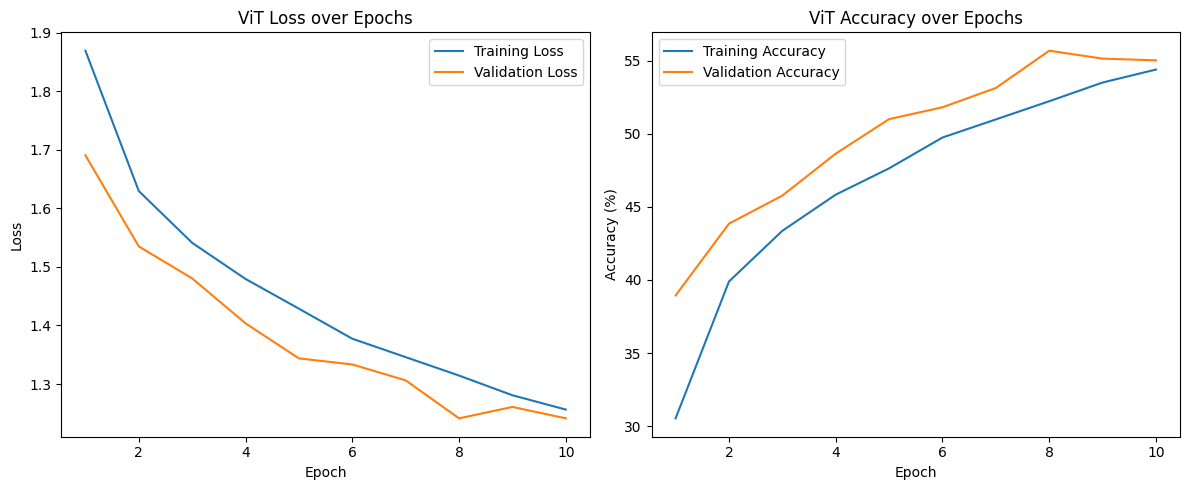

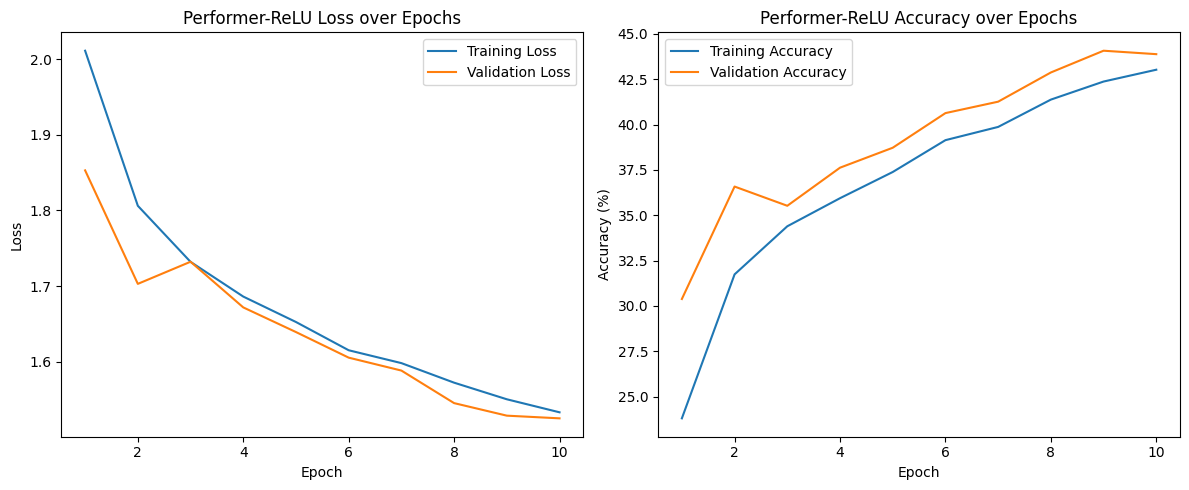

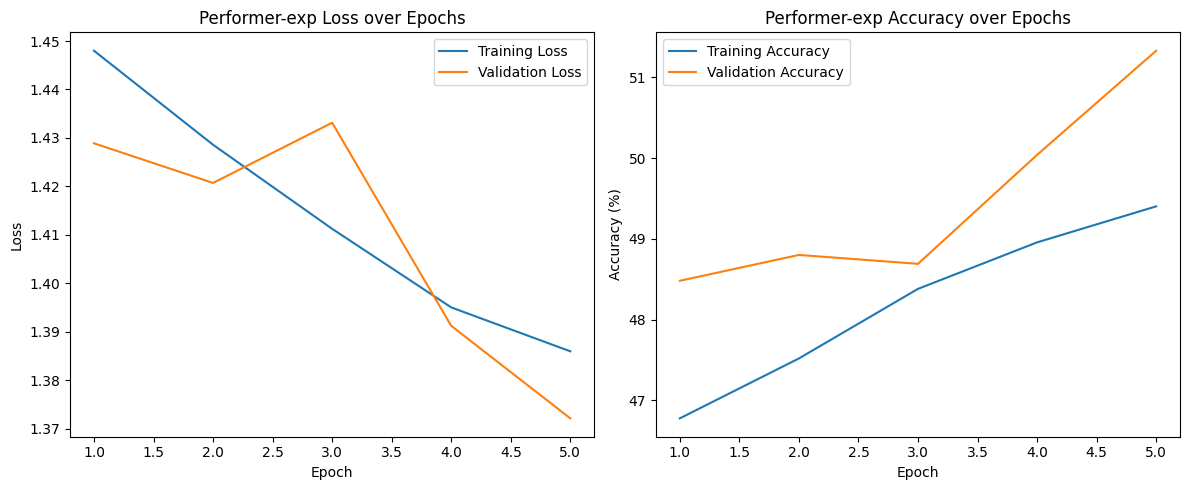

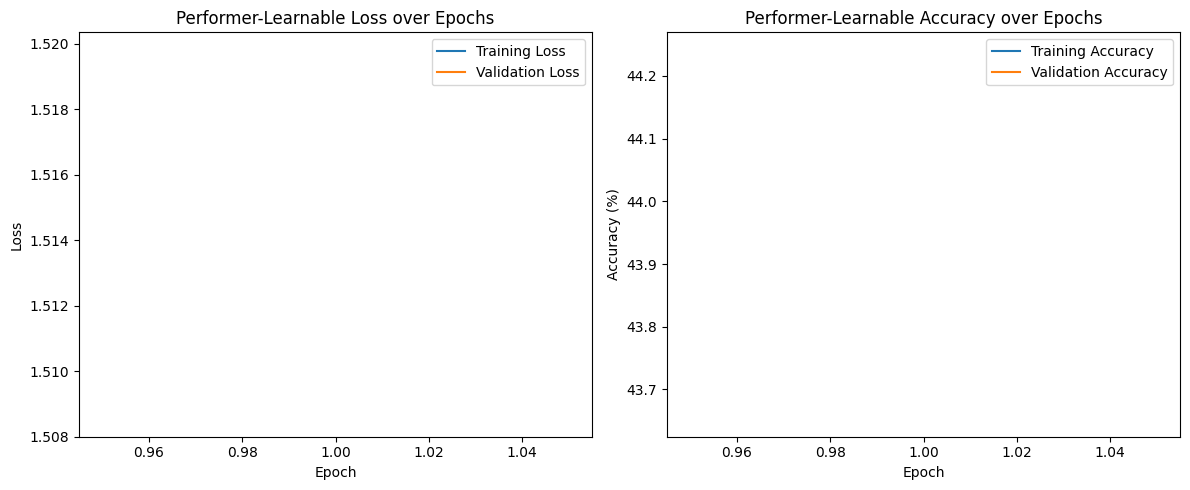

In [8]:
def plot_metrics(model_name):
    with open(f'{model_name}_metrics.pkl', 'rb') as f:
        metrics = pickle.load(f)

    epochs = range(1, len(metrics['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_losses'], label='Training Loss')
    plt.plot(epochs, metrics['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracies'], label='Training Accuracy')
    plt.plot(epochs, metrics['val_accuracies'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics('ViT')
plot_metrics('Performer-ReLU')
plot_metrics('Performer-exp')
plot_metrics('Performer-Learnable')

In [14]:
def get_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Extracting Embeddings'):
            images = images.to(device)
            labels = labels.to(device)
            x = model.patch_embed(images)
            batch_size = x.size(0)
            cls_tokens = model.cls_token.expand(batch_size, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
            x = model.pos_embed(x)
            x = model.dropout(x)
            x = model.encoder(x)
            cls_output = x[:, 0]
            embeddings.append(cls_output.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    embeddings = np.concatenate(embeddings)
    labels_list = np.concatenate(labels_list)
    return embeddings, labels_list

Extracting Embeddings: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it]
/Users/GuidoDeFilippo/Columbia/Data_Mining/transformer_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


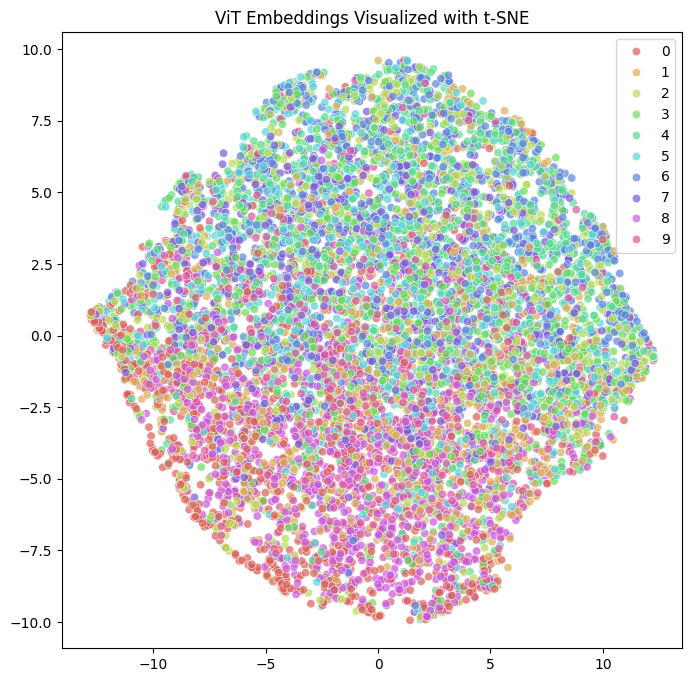

In [15]:
def plot_embeddings(embeddings, labels, model_name):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=labels,
        palette=sns.color_palette("hls", 10),
        legend='full',
        alpha=0.7
    )
    plt.title(f'{model_name} Embeddings Visualized with t-SNE')
    plt.show()

embeddings, labels = get_embeddings(vit_model, test_loader)
plot_embeddings(embeddings, labels, 'ViT')

Extracting Embeddings: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it]
/Users/GuidoDeFilippo/Columbia/Data_Mining/transformer_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


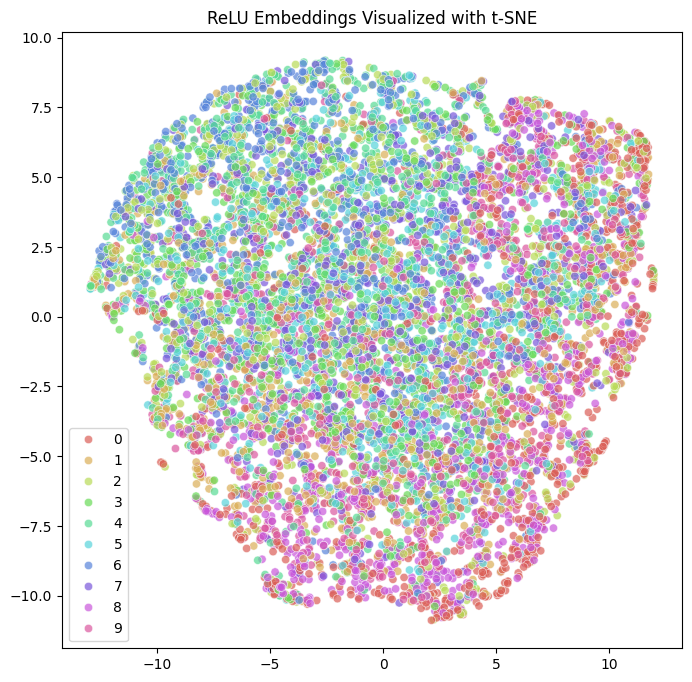

In [16]:
embeddings, labels = get_embeddings(performer_relu_model, test_loader)
plot_embeddings(embeddings, labels, 'ReLU')

In [9]:
def load_model(model_class, checkpoint_path):
    model = model_class(
        img_size=32,
        patch_size=8,            # Increased patch size from 4 to 8
        in_channels=3,
        num_classes=10,
        embed_dim=128,           # Reduced embedding dimension from 256 to 128
        num_heads=4,             # Reduced number of heads from 8 to 4
        hidden_dim=256,          # Reduced hidden dimension from 512 to 256
        num_layers=4,            # Reduced number of layers from 6 to 4
        dropout=0.1
    ).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.eval()
    return model

In [19]:
from torchvision import datasets, transforms

# Define the transform (you may already have this in your code)
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any other transforms you are using
])

# Access the class labels
class_labels = train_dataset.classes  # This is a list of class names
class_to_idx = train_dataset.class_to_idx  # This is a dictionary mapping class names to indices

print("Class Labels:")
for idx, label in enumerate(class_labels):
    print(f"{idx}: {label}")

Class Labels:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


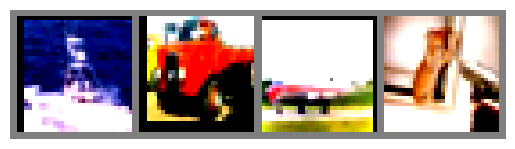

Labels:
8: ship
9: truck
0: airplane
3: cat


In [20]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if you have normalized the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels
print('Labels:')
for label in labels[:4]:
    print(f"{label.item()}: {class_labels[label]}")

In [10]:
vit_model = load_model(VisionTransformer, 'best_ViT.pth')
relu_model = load_model(PerformerReLUTransformer, 'best_Performer-ReLU.pth')

/var/folders/l3/4qywm6wn4273cj1z5n54pm_h0000gn/T/ipykernel_78395/2318784806.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

In [27]:
def classify_image(model, image):
    image = transform_test(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)
    return predicted.item()

# Load an image (e.g., from PIL or OpenCV)
from PIL import Image
image = Image.open('car.jpeg').convert('RGB').resize((32, 32))
label = classify_image(relu_model, image)
print(f'Predicted Label: {class_labels[label]}')

Predicted Label: automobile


In [28]:
def show_image_with_prediction(image, label):
    plt.imshow(image)
    plt.title(f'Predicted Label: {label}')
    plt.axis('off')
    plt.show()

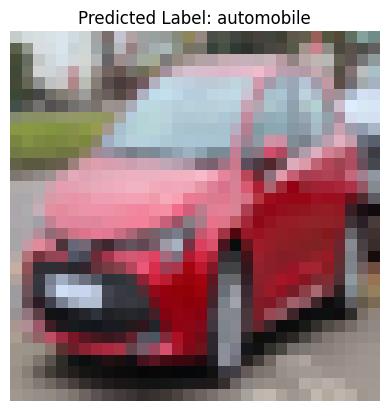

In [29]:
show_image_with_prediction(image, class_labels[label])

In [32]:
df = pd.read_csv('results.csv')
df.head()

,ViT,366.9849729537964,35.789835929870605,10.0
0,Performer-ReLU,255.794168,35.383376,26.42
1,Performer-exp,50243.304063,125.857676,10.66
2,Performer-Learnable,680.754935,71.387063,10.38
3,ViT,128.313405,72.835719,10.00
4,Performer-ReLU,115.171755,73.731156,27.71


In [30]:
import pandas as pd

def plot_comparisons():
    # Load results from 'results.csv'
    df = pd.read_csv('results.csv')

    # Plot Training Time
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model', y='Total Training Time', data=df)
    plt.title('Total Training Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.show()

    # Plot Inference Time
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model', y='Total Inference Time', data=df)
    plt.title('Total Inference Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model', y='Accuracy', data=df)
    plt.title('Validation Accuracy Comparison')
    plt.ylabel('Accuracy (%)')
    plt.show()

plot_comparisons()

ValueError: Could not interpret value `Model` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

In [ ]:
def plot_speed_accuracy():
    df = pd.read_csv('results.csv')
    df['Avg Inference Time per Image'] = df['Total Inference Time'] / len(test_dataset)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='Avg Inference Time per Image',
        y='Accuracy',
        hue='Model',
        data=df,
        s=100
    )
    plt.title('Speed-Accuracy Trade-off')
    plt.xlabel('Average Inference Time per Image (seconds)')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_speed_accuracy()

In [12]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image

# Initialize GradCAM with the desired layer
cam_extractor = GradCAM(model, target_layer='encoder.layers[-1]')

# Forward pass
out = model(image.unsqueeze(0).to(device))

# Retrieve the CAM by passing the class index
activation_map = cam_extractor(class_idx=out.argmax(dim=1).item(), scores=out)

# Visualize the CAM
plt.imshow(to_pil_image(image))
plt.imshow(activation_map.squeeze().cpu(), cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

ValueError: Unable to find all submodules ['encoder.layers[-1]'] in the model

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Example usage
plot_confusion_matrix(vit_model, test_loader)